# <font size="6" color="gray">Capítulo 9</font><br>

<font size="50" color="lighblue">Varios temas de aprendizaje profundo: <br> Técnicas de aprendizaje profundo para video
e inteligencia lingüística</font><br>

<font size="6" color="lighblue">Curso AI</font>


###Descripción del capítulo

#### *Objetivos del capítulo:*

* Construye y entrena redes neuronales convolucionales para la clasificación de imágenes.
* Redes neuronales convolucionales (CNN en inglés) para detectar patrones correlacionados localmente en imágenes.
* Construye y entrena redes neuronales recurrentes para el pronóstico de series temporales y el procesamiento del lenguaje natural.
* Breve descripción general del LSTM.
* AutoEncoders para reducción dimensional y extracción de características.
* Breve introducción a las redes generativas adversarias (GAN en inglés).

#### *Contenidos del capítulo:*

* Unidad 1. Modelo CNN
* **Unidad 2. RNN para modelado de datos secuenciales**
* Unidad 3. Red neuronal adversaria generativa (GAN) para crear imágenes inexistentes


## <font size="6" color="gray">Unidad 3.</font><br>

<font size="50" color="lighblue">Red neuronal adversaria generativa para crear imágenes inexistentes</font> <br>

3.1. Codificador automático<br>
3.2. Acerca de las redes generativas adversarias (GAN)<br>
**3.3. Ejercicio de redes generativas adversarias**<br>

### Red neuronal convolucional (CNN)

#### Entrenamiento del modelo `GAN` en Google Colab

* El ejercicio de código de este capítulo requiere `mayores recursos` que una computadora portátil sin la `GPU` o la potencia informática de una estación de trabajo.
</br>

* Si tienes una computadora con `GPU NVIDIA` y has instalado la librería `cuDNN`, puedes aumentar la velocidad de cálculo.
</br>

* Aquí utilizaremos `Google Colab`, un servicio gratuito de computación en la nube, porque estos recursos informáticos de alto rendimiento generalmente no están disponibles.
</br>

* Google Colab ofrece instancias de `Jupyter Notebook` en la nube.
</br>

* Este Notebook se puede guardar en `Google Drive` o `GitHub`.
</br>

* Colab ofrece muchos recursos informáticos como `CPU`, `GPU` e incluso `TPU`, pero limita su tiempo de funcionamiento a 12 horas.
</br>

* La máquina asignada se apaga después de `12 horas` de funcionamiento.
</br>

* El ejercicio de código en este capítulo solo requiere un máximo de `2 a 3 horas`.
</br>

* Para proyectos que se ejecutan durante más de 12 horas, se recomienda guardar los resultados intermedios como archivos de `puntos de control`.

#### Entrenamiento del modelo GAN en Google Colab

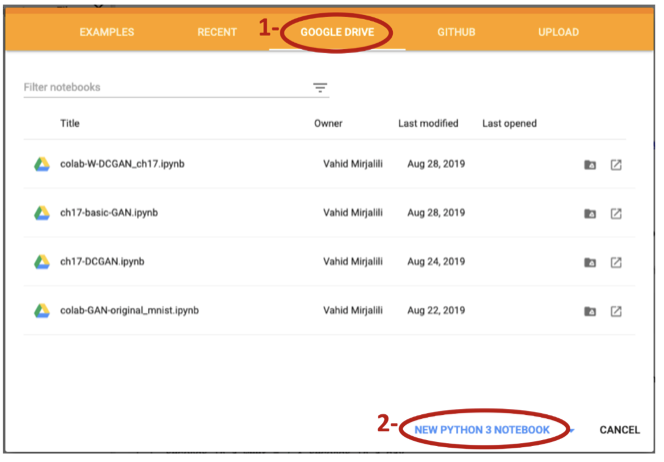

```
Google Colab es fácil de usar.
Si visitas https://colab.research.google.com, te preguntarás dónde guardar Jupyter Notebook.
Haz clic en la pestaña Google Drive en esta ventana.
Al hacer esto, puedes guardar el Notebook en Google Drive.
Luego, haz clic en el enlace del nuevo Notebook al final para crear un nuevo Notebook.
```

#### Construyendo un modelo GAN desde cero

* Como siguiente paso, veamos cómo ejecutar el código de la computadora portátil usando `GPU`:

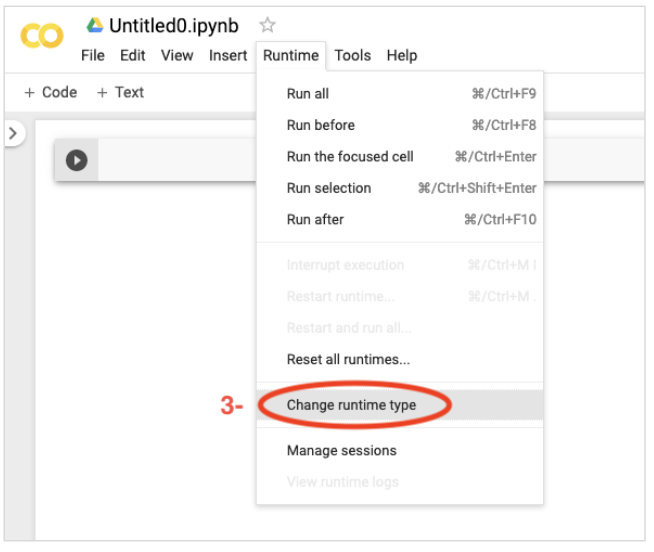

* Elige el `entorno de ejecución` en la barra de menú, haciendo clic en Cambio de tipo de tiempo de ejecución y selecciona `GPU` como en la figura:

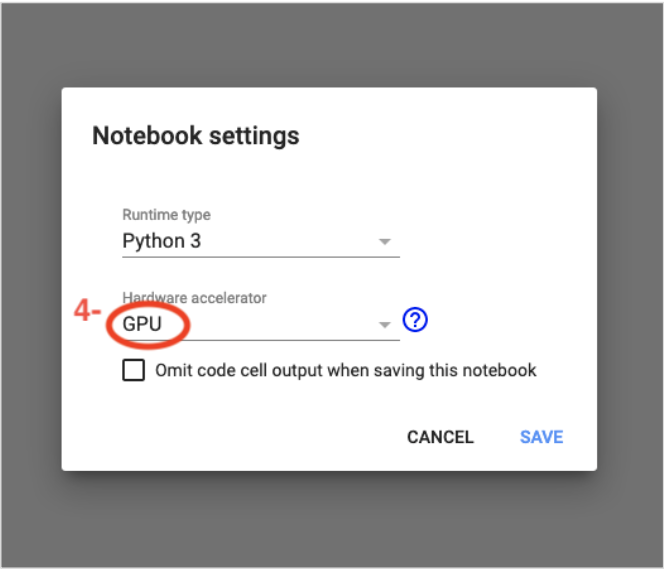

#### Entrenamiento del modelo GAN en Google Colab

* Verifiquemos la compatibilidad de GPU para la versión instalada de TensorFlow usando el siguiente código:

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
print("GPU compatibility:", len(tf.config.list_physical_devices("GPU")) > 0)

if tf.config.list_physical_devices("GPU"):
  device_name = tf.test.gpu_device_name( )
else:
  device_name = 'cpu: 0'

print(device_name)

GPU compatibility: True
/device:GPU:0


#### Construcción de redes neuronales generadoras y discriminadoras.

* Construyamos el generador y discriminador del primer modelo GAN como una red neuronal completamente conectada con una o más capas ocultas (consulta la siguiente figura).
</br>

* Este modelo es la versión GAN original y se llama vanilla GAN.

 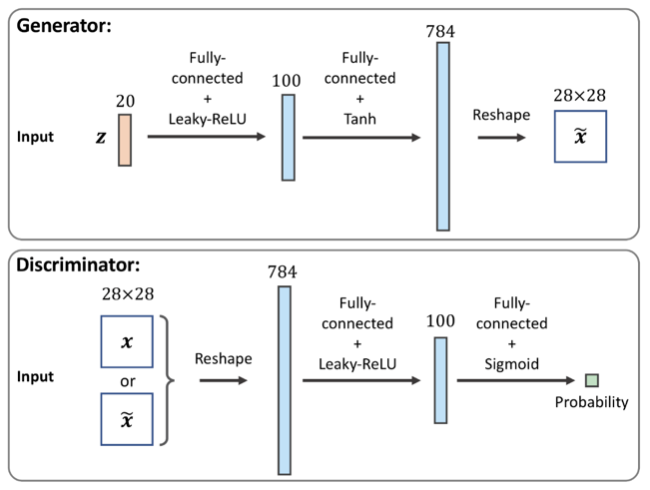

* Este modelo utiliza la función de activación LeakyReLu para cada capa oculta.
* ReLu produce un gradiente escaso. Sin embargo, esto no es adecuado para casos en los que se necesitan gradientes en todos los rangos de valores de entrada.
* En la red neuronal discriminadora, la capa de abandono sigue a la capa oculta.
* La capa de salida del generador utiliza la función de activación de tangente hiperbólica (tanh). El uso de la función de activación tanh en la red neuronal del generador ayuda al proceso de aprendizaje.
* La capa de salida del discriminador no tiene una función de activación para calcular el logit (es decir, utiliza la función de activación lineal).
* O podría usar la función de activación sigmoidea para devolver la probabilidad como salida.



#### Definamos las dos funciones auxiliares para las dos redes neuronales.

* Esta función construye un modelo con la clase Keras Sequential, y el código con la capa mencionada es el siguiente:

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Definir la función del generador:

def make_generator_network(
    num_hidden_layers = 1,
    num_hidden_units = 100,
    num_output_units = 784):
  model = tf.keras.Sequential()
  for i in range (num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            units = num_hidden_units,
            use_bias = False)
        )
    model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Dense(
      units=num_output_units, activation='tanh'))
  return model


In [ ]:
## Definir la función discriminadora:
def make_discriminator_network(
    num_hidden_layers = 1,
    num_hidden_units = 100,
    num_output_units = 1):
  model = tf.keras.Sequential()
  for i in range (num_hidden_layers) :
    model.add(tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate = 0.5))

  model.add(
      tf.keras.layers.Dense(
          units = num_output_units,
          activation = None)
      )
  return model


* Configuramos para entrenar el siguiente modelo.
* El tamaño de la imagen MNIST es de 28 x 28 píxeles. El archivo MNIST tiene un solo canal de color ya que es una imagen en blanco y negro.
* Luego, establezca el tamaño del vector de entrada z en 20 e inicialice aleatoriamente el valor de peso a partir de una distribución uniforme.
* Usaremos capas completamente conectadas y una única capa oculta con 100 unidades en cada red neuronal para construir una GAN muy simple que sirva como ejemplo.
* Generamos e inicializamos dos redes neuronales en el siguiente código.
* Cargue el método summary() de Keras.

In [ ]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_size,
    num_output_units = np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81184 (317.12 KB)
Trainable params: 81184 (317.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
disc_model = make_discriminator_network(
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78601 (307.04 KB)
Trainable params: 78601 (307.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Definir conjunto de datos de prueba

* Como siguiente paso, carguemos el conjunto de datos MNIST y apliquemos los pasos de preprocesamiento necesarios.
* El rango de valores de píxeles de la imagen sintética es (-1, 1) ya que la capa de salida del generador utiliza la función de activación tanh.
* El rango de píxeles de la imagen MNIST de entrada es [0,255] (tipo de datos tf.unit8 de TensorFlow).
* En la etapa de preprocesamiento, cambie el tipo del tensor de imagen de entrada de tf.uint8 a tf.float32 usando la función tf.image.convert_image_dtype.

In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess (ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform (
        shape=(z_size,), minval=-1.0, maxval =1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


* Al cargar esta función también se cambia el rango de intensidad de píxeles a [0, 1].
* Multiplica 2 y resta 1 para ajustar el rango de intensidad de píxeles a [-1, 1].
* También cree un vector aleatorio z basado en una distribución aleatoria (distribución estándar o normal ampliamente utilizada en este código).
* Aquí, devolvemos colectivamente el vector de entrada z y la imagen extraída del conjunto de datos de entrenamiento por conveniencia.

#### Examinemos el objeto del conjunto de datos:

In [ ]:
mnist_trainset = mnist['train']

print('before preprocessing: ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ('minimum: {}, maximum: {}'.format(np.min(example), np.max(example))))

mnist_trainset = mnist_trainset.map(preprocess)

print('after preprocessing: ')
example = next(iter(mnist_trainset))[0]
print ('dtype: ', example.dtype, ('minimum: {}, maximum: {}'.format(np.min(example), np.max(example))))

before preprocessing: 
dtype:  <dtype: 'uint8'> minimum: 0, maximum: 255
after preprocessing: 
dtype:  <dtype: 'float32'> minimum: -0.8737728595733643, maximum: 0.9460210800170898


#### En el siguiente código, imprimamos el vector de entrada y la forma de la matriz de imágenes extrayendo un lote:

In [ ]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

input-z -- shape: (32, 20)
input-real -- shape: (32, 784)


#### Además, ejecutemos el cálculo de propagación frontal del generador y discriminador para comprender el flujo de datos general.

* Primero, que devuelva la salida g_output insertando el lote de vector de entrada z en el generador.
* Este es el lote de la muestra falsa.
* Después, que obtenga d_logits_fake, un logit por lotes de la muestra falsa, insertando el lote anterior en el modelo discriminador.
* Luego, obtenga d_logits_real, un logit para la imagen real, insertando la imagen preprocesada del objeto del conjunto de datos en el modelo discriminador.

 * Se utilizan dos logits, d_logits_fake y d_logits_real, para calcular la función de pérdida durante el entrenamiento.

In [ ]:
g_output = gen_model(input_z)
print('Generator output -- shape:', g_output.shape)

d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('discriminator (real) -- shape:', d_logits_real.shape)
print('discriminator (fake) -- shape:', d_logits_fake.shape)

Generator output -- shape: (32, 784)
discriminator (real) -- shape: (32, 1)
discriminator (fake) -- shape: (32, 1)


#### Entrenamiento del modelo GAN

* A continuación, cree un objeto de clase BinaryCrossentropy para que la función de pérdida calcule la pérdida del generador y del discriminador del lote procesado anteriormente.
* Para esta operación es necesaria una etiqueta de respuesta para cada salida.
* Creemos un vector lleno de 1 para el generador.
* El tamaño de este vector es idéntico al del vector d_logits_fake, que contiene el valor logit de la imagen generada.

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Generador de pérdida
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator loss: {:.4f}'.format(g_loss))

Generator loss: 0.6487


* El discriminador necesita dos pérdidas.
* Calculemos la pérdida que detecta una muestra falsa usando d_logits_fake y calculemos la pérdida que detecta una muestra real usando d_logits_real.

In [ ]:
## Discriminador de pérdida
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)

print('Discriminator loss: real {:.41}, fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator loss: real 0.139059245586395263671875, fake 0.7427


In [ ]:
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

## Entrenamiento final (1/6)

import time

num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
      shape=(batch_size, z_size), minval=-1, maxval=1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(
      shape=(batch_size, z_size))

def create_samples(g_model, input_z):
  g_output = g_model (input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

## Preparar conjunto de datos
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess (ex, mode=mode_z))

## Entrenamiento final (2/6)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Entrenamiento final (3/6)

# Función para encapsular el bucle de entrenamiento.
@tf.function
def train_step(input_z, input_real, gen_model, disc_model, g_optimizer, d_optimizer, loss_fn):
    # Calcula la pérdida del generador
    with tf.GradientTape() as g_tape:
        g_output = gen_model(input_z)
        d_logits_fake = disc_model(g_output, training=True)
        labels_real = tf.ones_like(d_logits_fake)
        g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)

        # Calcula el gradiente de g_loss.
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)

        # Optimizador: Aplicar gradientes.
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

    # Calculemos la pérdida del discriminador.
    with tf.GradientTape() as d_tape:
        d_logits_real = disc_model(input_real, training=True)

        d_labels_real = tf.ones_like(d_logits_real)

        d_loss_real = loss_fn(
            y_true=d_labels_real, y_pred=d_logits_real)

        d_logits_fake = disc_model(g_output, training=True)
        d_labels_fake = tf.zeros_like(d_logits_fake)

        d_loss_fake = loss_fn(
            y_true=d_labels_fake, y_pred=d_logits_fake)

        d_loss = d_loss_real + d_loss_fake

    # Calculamos el gradiente de d_loss.
    d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)

    # Optimizador: Aplicar gradientes
    d_optimizer.apply_gradients(
        grads_and_vars=zip(d_grads, disc_model.trainable_variables))

    return g_loss, d_loss, d_loss_real, d_loss_fake, d_logits_real, d_logits_fake

## Preparar el modelo
with tf.device(device_name):
  gen_model = make_generator_network(
      num_hidden_layers = gen_hidden_layers,
      num_hidden_units = gen_hidden_size,
      num_output_units = np.prod(image_size))
  gen_model.build(input_shape = (None, z_size))

  disc_model = make_discriminator_network(
      num_hidden_layers = disc_hidden_layers,
      num_hidden_units = disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))

## Función de pérdida y optimizador.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

## Entrenamiento final (4/6)
#### Ejecuta la operación en la instrucción de bucle for en el código final para construir un modelo GAN e iterar el entrenamiento.

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i, (input_z, input_real) in enumerate(mnist_trainset):
        g_loss, d_loss, d_loss_real, d_loss_fake, d_logits_real, d_logits_fake = train_step(
            input_z, input_real, gen_model, disc_model, g_optimizer, d_optimizer, loss_fn)

        epoch_losses.append((g_loss.numpy(), d_loss.numpy(),
                            d_loss_real.numpy(), d_loss_fake.numpy()))

        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))

    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'epoch {:03d} | time {:.2f} min | Average loss >>'
        ' Generator/Discriminator {:.4f}/{:.4f} [Discriminator-Real]: {:.4f} Discriminator-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60,
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())


epoch 001 | time 0.21 min | Average loss >> Generator/Discriminator 3.0367/0.2873 [Discriminator-Real]: 0.0375 Discriminator-Fake: 0.2498]
epoch 002 | time 0.38 min | Average loss >> Generator/Discriminator 5.3897/0.3332 [Discriminator-Real]: 0.1058 Discriminator-Fake: 0.2275]
epoch 003 | time 0.48 min | Average loss >> Generator/Discriminator 3.2361/0.6518 [Discriminator-Real]: 0.2925 Discriminator-Fake: 0.3593]
epoch 004 | time 0.60 min | Average loss >> Generator/Discriminator 2.2977/0.8492 [Discriminator-Real]: 0.4364 Discriminator-Fake: 0.4128]
epoch 005 | time 0.71 min | Average loss >> Generator/Discriminator 2.1145/0.7897 [Discriminator-Real]: 0.4314 Discriminator-Fake: 0.3584]
epoch 006 | time 0.83 min | Average loss >> Generator/Discriminator 2.0618/0.8365 [Discriminator-Real]: 0.4523 Discriminator-Fake: 0.3842]
epoch 007 | time 0.93 min | Average loss >> Generator/Discriminator 1.6431/0.9565 [Discriminator-Real]: 0.5239 Discriminator-Fake: 0.4326]
epoch 008 | time 1.06 min |

<font color=gray>NOTA: Si utilizas GPU en Google Colab, el proceso de entrenamiento del código mencionado se realizará en una hora (más rápido en computadoras con las últimas CPU y GPU).
Se aconseja analizar el proceso de entrenamiento de las dos redes neuronales y ver cómo evaluar su convergencia imprimiendo un gráfico de pérdidas del discriminador y del generador.</font>

## Entrenamiento del modelo GAN

* Además, resulta útil imprimir la probabilidad promedio de las muestras reales y falsas calculadas por el discriminador para cada iteración.
* Si esta probabilidad es cercana a 0,5, el discriminador no puede distinguir entre imágenes reales y falsas.

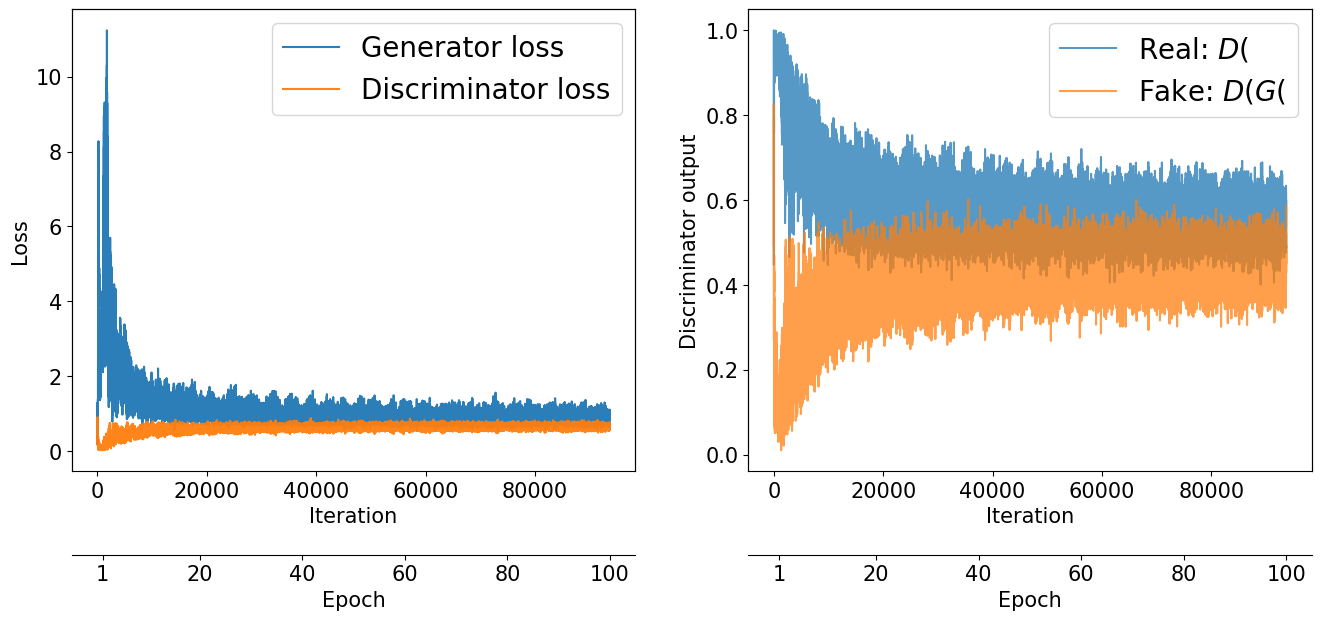

In [ ]:
import itertools

fig = plt.figure(figsize=(16, 6))

## Gráfica de pérdidas
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel ('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both' , which='major' , labelsize=15)
ax2.tick_params(axis='both', which='major' , labelsize=15)

## Imprimir el discriminador
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label = r'Real: $D(#mathbf{x))$')
plt.plot(d_vals_fake, alpha=0.75, label = r'Fake: $D(G(#mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax. set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2. set_xlabel ('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both' , which='major' , labelsize=15)
ax2.tick_params(axis='both', which='major' , labelsize=15)

plt.show()

## Entrenamiento del modelo GAN

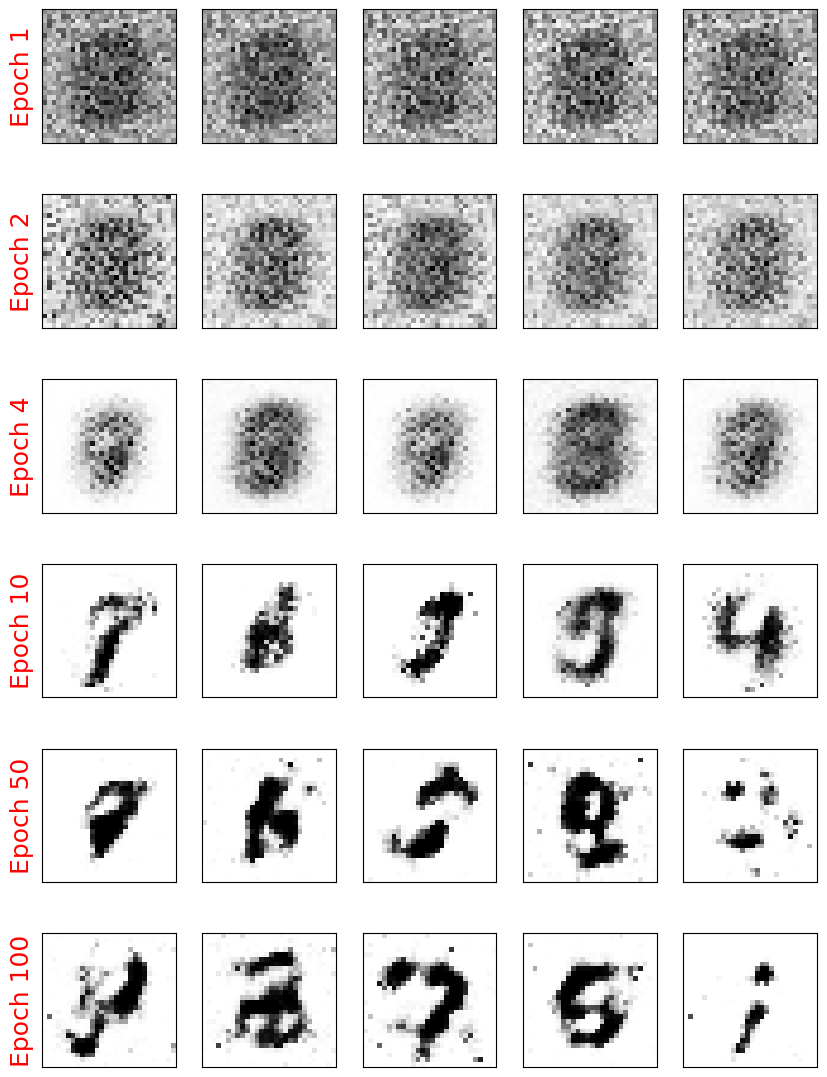

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, 'Epoch {}'.format(e),
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes)

    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()